# Try models

In [14]:
import glob
import re
import pickle

import numpy as np
import pandas as pd
from isoweek import Week
from pandas_summary import DataFrameSummary
import itertools
import utils
import lightgbm as lgb
import random
import matplotlib.pyplot as plt, xgboost, operator, random, pickle
# from keras.models import model_from_yaml
from pandas_summary import DataFrameSummary
from importlib import reload
reload(utils)
import matplotlib

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20.0, 20.0)

import math
def rmsle(y_pred, targ):
    log_vars = np.log(targ + 1) - np.log(y_pred + 1)
    return math.sqrt(np.square(log_vars).mean())
def plot_impt(model):
    importance = model.get_fscore()
    importance = sorted(importance.items(), key=operator.itemgetter(1))

    df = pd.DataFrame(importance, columns=['feature', 'fscore'])
    df['fscore'] = df['fscore'] / df['fscore'].sum()

    df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
    plt.title('XGBoost Feature Importance')
    plt.xlabel('relative importance');
    # df[df.fscore < 0.009].feature.tolist()

def rmsle_wo_log(y_predicted, y_true):
    y_true = y_true.get_label()
    y_predicted_orig = utils.log_max_inv(y_predicted, max_log_y)
    y_true_orig = utils.log_max_inv(y_true, max_log_y)
    score = rmsle(y_predicted_orig, y_true_orig)
    return ('rmsle', score, False)

def rmsle_wo_log_sk(y_predicted, y_true):
    y_predicted_orig = utils.log_max_inv(y_predicted, max_log_y)
    y_true_orig = utils.log_max_inv(y_true, max_log_y)
    score = rmsle(y_predicted_orig, y_true_orig)
    return score

In [2]:
def split(df):
    trn_len = int(np.floor(len(df) * 0.9))
    valid_len = len(df) - trn_len
    df['type'] = 0  #0 for train 1 for valid
    indexs = df.index
    df = df.reset_index()
    df.loc[trn_len:, 'type'] =  1
    return df
data_raw = pd.read_csv('./data/air_visit_data.csv')
test = pd.read_csv('./data/sample_submission.csv')
test_data = utils.tes2trn(test)
test_stores = test_data.air_store_id.unique()
data = data_raw[data_raw.air_store_id.isin(test_stores)]
tag_data = data.groupby('air_store_id').apply(split)
t = tag_data.set_index('index')
train_set = t[t.type == 0]
valid_set = t[t.type == 1]
train_set = train_set.reset_index().drop(['index', 'type'], axis=1)
valid_set = valid_set.reset_index().drop(['index', 'type'], axis=1)

len(train_set), len(train_set.air_store_id.unique()), len(valid_set), len(valid_set.air_store_id.unique())

(225049, 821, 25419, 821)

In [19]:
reload(utils)
trn_data = utils.get_data(train_set)
X_train = trn_data['X']
y_train = trn_data['Y']
y_train_orig = trn_data['Y_org']
max_log_y = trn_data['max_log_y']
g_y_trn = trn_data['gadge']
contin_map_fit = trn_data['contin_map_fit']
cat_map_fit = trn_data['cat_map_fit']
all_vars = trn_data['all_vars']


val_data = utils.get_data(valid_set, contin_map_fit=contin_map_fit, cat_map_fit=cat_map_fit)
X_valid = val_data['X']
y_valid = val_data['Y']
y_valid_orig = val_data['Y_org']
g_y_valid = val_data['gadge']

/Users/kevindu/Documents/workspace/ml_utils/proj/RRVF/utils.py:651: RuntimeWarning: invalid value encountered in log1p
  max_log_y = np.max(np.log1p(y_orig))
/Users/kevindu/Documents/workspace/ml_utils/proj/RRVF/utils.py:652: RuntimeWarning: invalid value encountered in log1p
  return np.log1p(y_orig) / max_log_y


In [20]:
X_train.shape

(225049, 16)

In [ ]:
categorical_feature=cat_vars, feature_name=all_vars, 

In [21]:
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, y_train.ravel(), free_raw_data=False)
lgb_eval = lgb.Dataset(X_valid, y_valid.ravel(), reference=lgb_train, free_raw_data=False)

In [28]:
# specify your configurations as a dict
params = {
    'task': 'train',
#     'boosting_type': 'dart',
    'objective': 'regression',
#     'metric': {'mse'},
    'num_leaves': 80,
    'learning_rate': 0.08,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'max_bin': 15,
    'max_depth': 40
}
evals_result = {} 
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=300,
                valid_sets=(lgb_train, lgb_eval),
                feval=rmsle_wo_log,
                evals_result=evals_result,
                ) # early_stopping_rounds=0

[1]	training's rmsle: 0.766697	valid_1's rmsle: 0.759454
[2]	training's rmsle: 0.731303	valid_1's rmsle: 0.726172
[3]	training's rmsle: 0.699861	valid_1's rmsle: 0.696749
[4]	training's rmsle: 0.672138	valid_1's rmsle: 0.669819
[5]	training's rmsle: 0.647732	valid_1's rmsle: 0.649003
[6]	training's rmsle: 0.626246	valid_1's rmsle: 0.631691
[7]	training's rmsle: 0.607458	valid_1's rmsle: 0.615822
[8]	training's rmsle: 0.591082	valid_1's rmsle: 0.603055
[9]	training's rmsle: 0.576891	valid_1's rmsle: 0.592959
[10]	training's rmsle: 0.564595	valid_1's rmsle: 0.584317
[11]	training's rmsle: 0.558366	valid_1's rmsle: 0.576661
[12]	training's rmsle: 0.548572	valid_1's rmsle: 0.570008
[13]	training's rmsle: 0.540121	valid_1's rmsle: 0.563746
[14]	training's rmsle: 0.532856	valid_1's rmsle: 0.558413
[15]	training's rmsle: 0.526661	valid_1's rmsle: 0.555089
[16]	training's rmsle: 0.521296	valid_1's rmsle: 0.552035
[17]	training's rmsle: 0.516656	valid_1's rmsle: 0.549055
[18]	training's rmsle: 

[144]	training's rmsle: 0.485497	valid_1's rmsle: 0.530325
[145]	training's rmsle: 0.485475	valid_1's rmsle: 0.530098
[146]	training's rmsle: 0.485451	valid_1's rmsle: 0.530099
[147]	training's rmsle: 0.485424	valid_1's rmsle: 0.529984
[148]	training's rmsle: 0.485403	valid_1's rmsle: 0.529928
[149]	training's rmsle: 0.48538	valid_1's rmsle: 0.529931
[150]	training's rmsle: 0.485358	valid_1's rmsle: 0.529889
[151]	training's rmsle: 0.485337	valid_1's rmsle: 0.529912
[152]	training's rmsle: 0.48532	valid_1's rmsle: 0.529922
[153]	training's rmsle: 0.485298	valid_1's rmsle: 0.529925
[154]	training's rmsle: 0.485278	valid_1's rmsle: 0.530007
[155]	training's rmsle: 0.485254	valid_1's rmsle: 0.530035
[156]	training's rmsle: 0.485229	valid_1's rmsle: 0.530063
[157]	training's rmsle: 0.485208	valid_1's rmsle: 0.530011
[158]	training's rmsle: 0.48519	valid_1's rmsle: 0.53004
[159]	training's rmsle: 0.485171	valid_1's rmsle: 0.530023
[160]	training's rmsle: 0.485149	valid_1's rmsle: 0.530044
[

[284]	training's rmsle: 0.482836	valid_1's rmsle: 0.525832
[285]	training's rmsle: 0.482826	valid_1's rmsle: 0.525693
[286]	training's rmsle: 0.482809	valid_1's rmsle: 0.525682
[287]	training's rmsle: 0.482786	valid_1's rmsle: 0.525675
[288]	training's rmsle: 0.482778	valid_1's rmsle: 0.525679
[289]	training's rmsle: 0.482756	valid_1's rmsle: 0.525662
[290]	training's rmsle: 0.482742	valid_1's rmsle: 0.525562
[291]	training's rmsle: 0.48273	valid_1's rmsle: 0.525569
[292]	training's rmsle: 0.482714	valid_1's rmsle: 0.525598
[293]	training's rmsle: 0.482705	valid_1's rmsle: 0.525616
[294]	training's rmsle: 0.482697	valid_1's rmsle: 0.525659
[295]	training's rmsle: 0.482683	valid_1's rmsle: 0.52568
[296]	training's rmsle: 0.482668	valid_1's rmsle: 0.525714
[297]	training's rmsle: 0.482656	valid_1's rmsle: 0.525752
[298]	training's rmsle: 0.482634	valid_1's rmsle: 0.525788
[299]	training's rmsle: 0.482624	valid_1's rmsle: 0.525595
[300]	training's rmsle: 0.482615	valid_1's rmsle: 0.525552

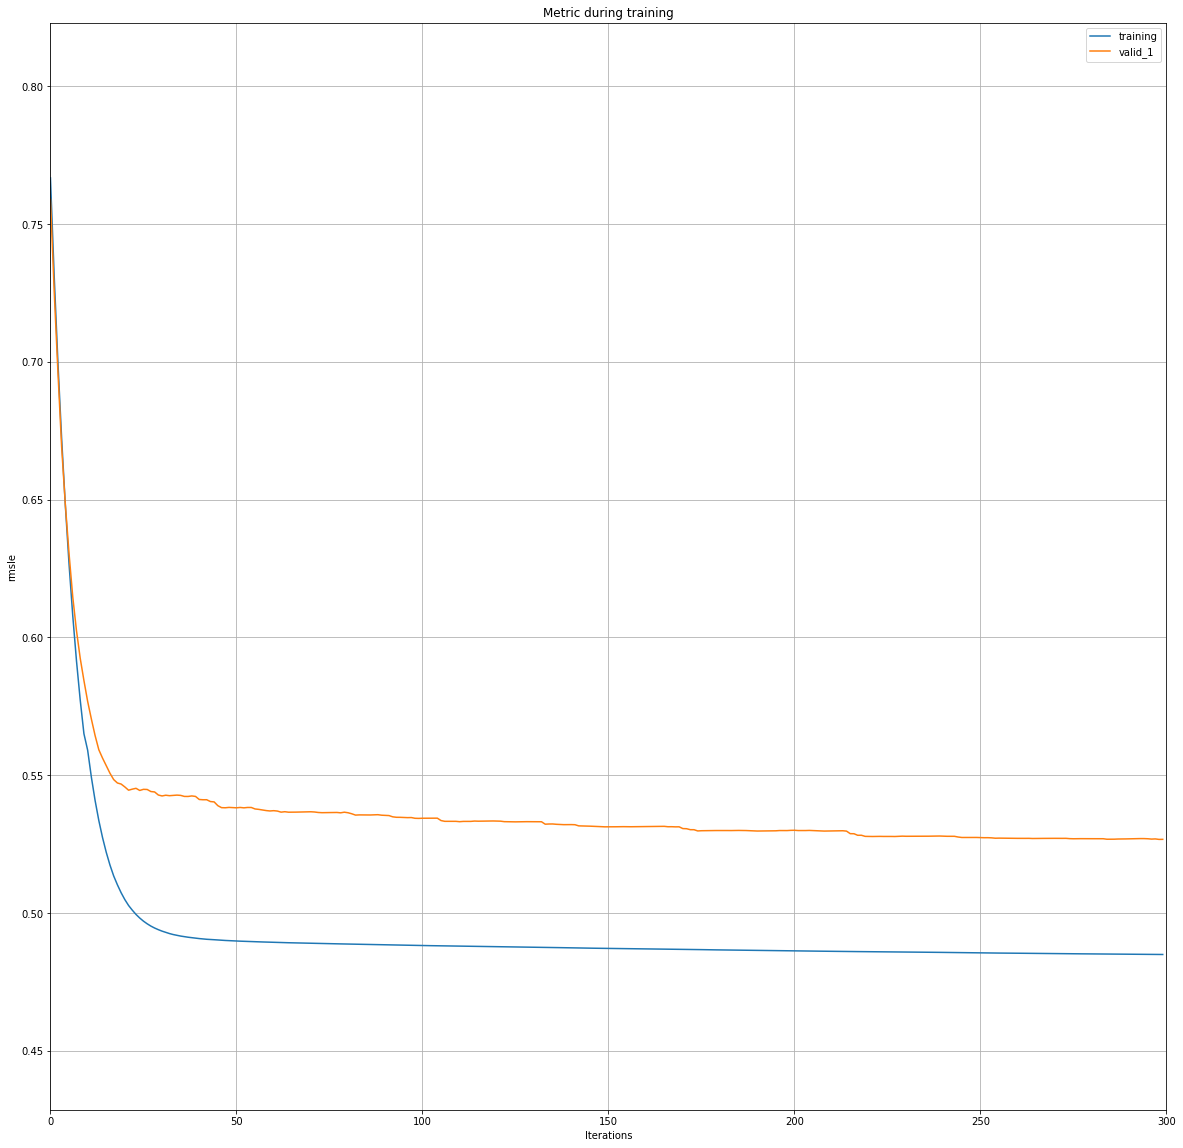

In [27]:
ax = lgb.plot_metric(evals_result, metric='rmsle')
# ax = lgb.plot_importance(gbm, max_num_features=10)


In [ ]:
def verify_linear(X_train, y_train, y_valid_orig, y_train_orig, max_log_y):
    from sklearn import linear_model

    reg = linear_model.LinearRegression()
    reg.fit(X_train, y_train)
    pred_valid = reg.predict(X_valid)
    pred_valid_orig = utils.log_max_inv(pred_valid, max_log_y)
    # pred_valid_orig = pred_valid
    valid_loss = rmsle(pred_valid_orig, y_valid_orig)
    pred_trn = reg.predict(X_train)
    pred_trn_orig = utils.log_max_inv(pred_trn, max_log_y)
    # pred_trn_orig = pred_trn
    trn_loss = rmsle(pred_trn_orig, y_train_orig)
#     plt.figure(1)
#     plt.plot(pred_valid_orig[:100], c='b')
#     plt.plot(y_valid_orig[:100], c='r')
    print('Linear Model train loss: {}, valid loss: {}'.format( trn_loss, valid_loss))
    return reg

reg = verify_linear(X_train, y_train, y_valid_orig, y_train_orig, max_log_y)

y_train_orig = train_set.visitors.values

base_valid= rmsle(g_y_trn.values, y_train_orig.ravel())
base_trn= rmsle(g_y_valid.values, y_valid_orig.ravel())

print('Base line train loss {}, valid loss {}'.format(base_trn, base_valid))

# split_point = X.shape[0] - y_valid_orig.ravel().shape[0]
# base_line = rmsle(tidy_data['prop_yhat'].values[split_point:].ravel(), y_valid_orig.ravel())

pred_valid = gbm.predict(X_valid)
pred_valid_orig = utils.log_max_inv(pred_valid, max_log_y)
valid_loss = rmsle(pred_valid_orig, y_valid_orig.ravel())
pred_trn = gbm.predict(X_train)
pred_trn_orig = utils.log_max_inv(pred_trn, max_log_y)
trn_loss = rmsle(pred_trn_orig, y_train_orig.ravel())
print('LightBGM train loss: {}, valid loss: {}'.format(trn_loss, valid_loss))

# plt.figure(2)
# plt.plot(pred_valid_orig[:100], c='b')
# plt.plot(y_valid_orig[:100], c='r')

# Submit


In [8]:
data_dir = r'./data'
test = pd.read_csv('{}/sample_submission.csv'.format(data_dir))
trn_like_test = utils.tes2trn(test)
trn_like_test = trn_like_test.assign(visitors = np.round(np.random.rand(len(trn_like_test)) * 100))

test_data = utils.get_data(trn_like_test, contin_map_fit=contin_map_fit, cat_map_fit=cat_map_fit)
X_tst= test_data['X']
y_tst = test_data['Y']
g_y_tst = test_data['gadge']

/Users/kevindu/Documents/workspace/ml_utils/proj/RRVF/utils.py:651: RuntimeWarning: invalid value encountered in log1p
  max_log_y = np.max(np.log1p(y_orig))
/Users/kevindu/Documents/workspace/ml_utils/proj/RRVF/utils.py:652: RuntimeWarning: invalid value encountered in log1p
  return np.log1p(y_orig) / max_log_y


In [9]:

# pred_reg = utils.log_max_inv(reg.predict(X), max_log_y)
pred_gbm = utils.log_max_inv(gbm.predict(X_tst), max_log_y)

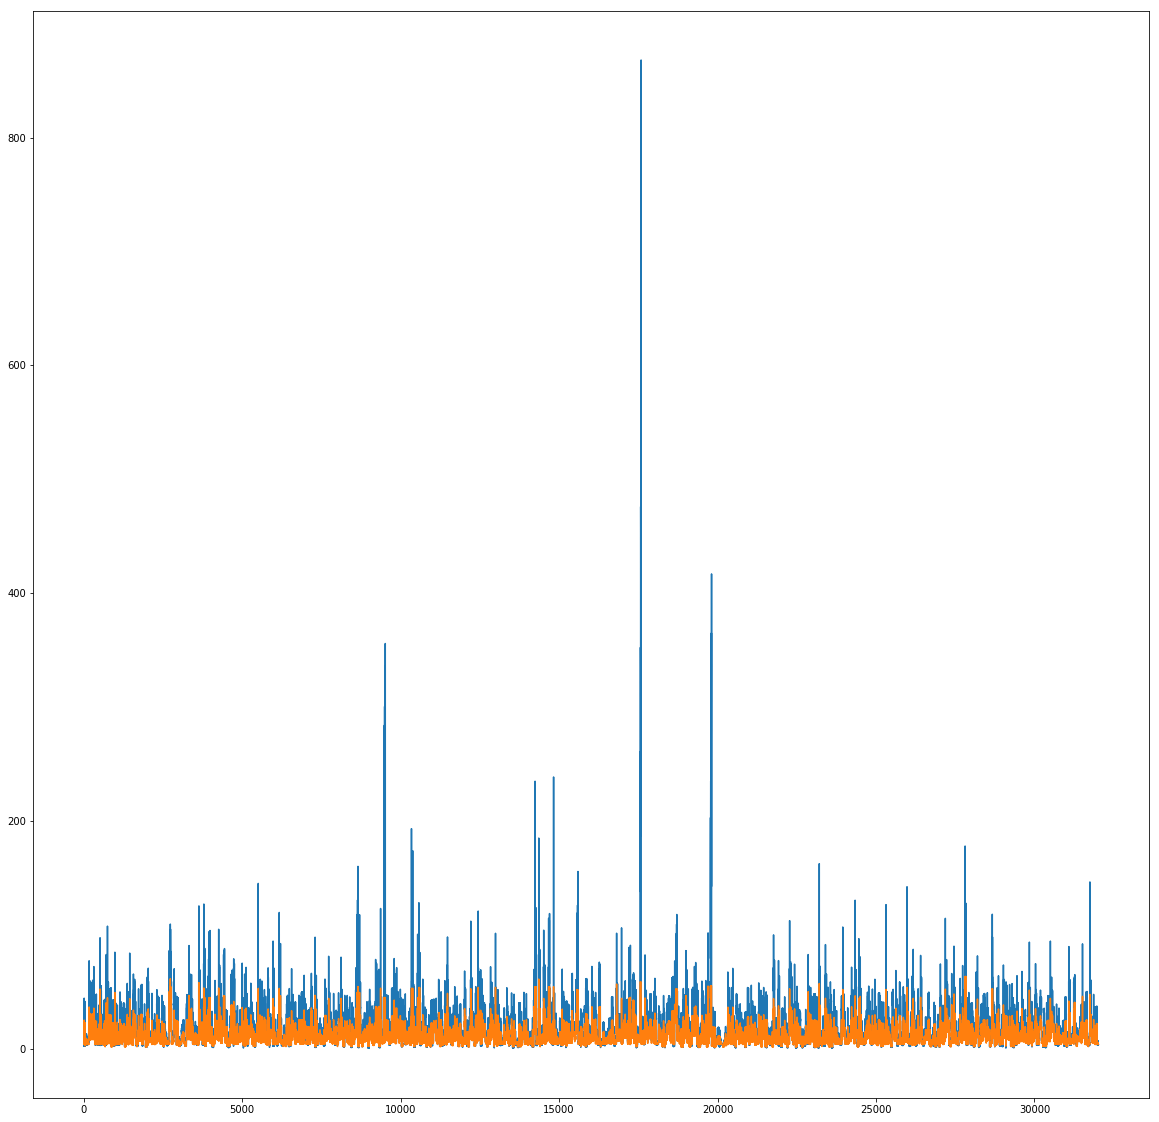

In [11]:
plt.plot(g_y_tst)
plt.plot(pred_gbm)

In [13]:
test.visitors = pred_gbm
test.to_csv('result/gbm.csv', index=False)
# test.visitors = pred_reg
# test.loc[test.visitors<0, "visitors"] = 0
# test.to_csv('result/reg.csv', index=False)